In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf

import keras
from keras.models import Sequential,Model
from keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,GlobalAveragePooling2D
from keras.utils.vis_utils import plot_model
from tensorflow.keras import regularizers
from keras.layers import Activation, Dropout, Flatten, Dense, Input
from keras.layers import BatchNormalization


import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import cv2
import os
import time
import sys

In [2]:

import tensorflow as tf
import numpy as np
from scipy.io import loadmat
from sklearn.preprocessing import StandardScaler
from scipy.io import savemat
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import mode 
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA

def ook(t):
  lb = LabelBinarizer()
  y_ook = lb.fit_transform(t)  

  if len(np.unique(t))==2:
    y_ook = np.concatenate((1-y_ook.astype(bool), y_ook), axis = 1) 

  return y_ook


def scheduler1(step = 10, ratio = 1.2):
  def scheduler(epoch, lr):
    if epoch % step == 0 and epoch>1:
      return lr/ratio
    else:
      return lr
  return scheduler

In [3]:
# os.chdir('/content/drive/Shareddrives/Multiple Anotators/CrowdLayer/Notebooks')
# cwd = os.getcwd()
# sys.path.append("../Models")


# from Multiple_Annotators_C import MultipleAnnotators_Classification

import sys
sys.path.insert(1, '../input/multiple-annotators-c/')
#os.chdir('/Multiple Anotators-c/')
#cwd = os.getcwd()
sys.path.append('/input/multiple-annotators-c')
from Multiple_Annotators_C import MultipleAnnotators_Classification

# seed_value= 12321 
# from numpy.random import seed
# seed(seed_value)
# tf.random.set_seed(seed_value)

In [4]:
train_data = tf.data.experimental.load('../input/catsvsdog-ma/cats_dogs_Tr')
Test_data = tf.data.experimental.load('../input/catsvsdog-ma/cats_dogs_Te')

2023-02-14 04:38:56.270062: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-14 04:38:56.411557: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-14 04:38:56.412429: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-14 04:38:56.414515: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [5]:
image_count_train = tf.data.experimental.cardinality(train_data).numpy()
image_count_train

18610

In [6]:
image_count_test = tf.data.experimental.cardinality(Test_data).numpy()
image_count_test

4652

In [7]:
subset = 18610
train_data = train_data.take(18610)
image_count1 = tf.data.experimental.cardinality(train_data).numpy()
image_count1

18610

In [8]:
image_count = 3000
 
val_size = int(image_count1 * 0.25)
train_ds = train_data.skip(val_size)
val_ds  = train_data.take(val_size)

In [9]:
image_count_val = tf.data.experimental.cardinality(val_ds).numpy()
image_count_val

4652

In [10]:
image_count_Tr = tf.data.experimental.cardinality(train_ds).numpy()
image_count_Tr

13958

2023-02-14 04:38:59.424013: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


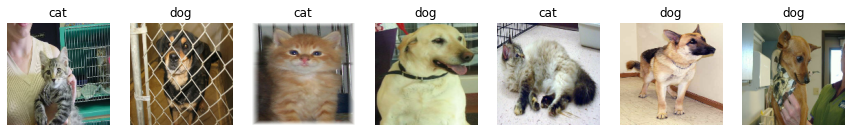

In [11]:
classNames = ['cat', 'dog']


i = 0

fig, ax = plt.subplots(1, 7, figsize=(15,15))
 
for image,label in train_ds.take(7):
 #  print(image.shape)
 #   predictedLabel = int(predictions[i] >= 0.5)
   # print(label)
   ax[i].axis('off')
   ax[i].set_title(classNames[label.numpy()])
   ax[i].imshow(image)
    
   i += 1
 
# plt.show()

In [12]:
# shuffle and create batches before training
batch_size = 128
train_batches = train_ds.shuffle(1024).batch(batch_size)
val_batches  = val_ds.shuffle(1024).batch(batch_size)
test_batches =  Test_data.shuffle(1024).batch(batch_size)

In [13]:
image_count_test = tf.data.experimental.cardinality(test_batches).numpy()
image_count_test

37

**Build the GOLD STANDARD classifier**


This will look familiar to you because it is almost identical to the previous model we built. The key difference is the output is just one unit that is sigmoid activated. This is because we're only dealing with two classes.

In [14]:
def build_base_model():
    # base_model = Sequential()


    # base_model.add( Conv2D(32, (3, 3), activation='relu',
    # input_shape=(150, 150, 3)))
    # base_model.add( MaxPooling2D((2, 2)))
    # base_model.add( Dropout(0.2))

    # base_model.add( Conv2D(64, (3, 3), activation='relu'))
    # base_model.add( MaxPooling2D((2, 2)))
    # base_model.add( Dropout(0.2))

    # base_model.add( Conv2D(128, (3, 3), activation='relu'))
    # base_model.add( MaxPooling2D((2, 2)))
    # base_model.add(Dropout(0.2))

    # base_model.add(Conv2D(256, (3, 3), activation='relu'))
    # base_model.add(MaxPooling2D((2, 2)))
    # base_model.add(Dropout(0.2))

    # base_model.add(Flatten())


    # base_model.add(Dense(256, activation='relu'))
    # base_model.add(Dense(1, activation='sigmoid'))

    initializer = tf.keras.initializers.GlorotNormal(seed=100)
    base_model = Sequential()
    base_model.add(BatchNormalization())
    base_model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3),bias_initializer='zeros', kernel_initializer=initializer))
    base_model.add(Activation('relu'))
    base_model.add(BatchNormalization())
    base_model.add(MaxPooling2D(pool_size=(2, 2)))
   # base_model.add(Dropout(0.2))
   
    base_model.add(BatchNormalization())
    base_model.add(Conv2D(32, (3, 3),bias_initializer='zeros', kernel_initializer=initializer))
    base_model.add(Activation('relu'))
    base_model.add(BatchNormalization())
    base_model.add(MaxPooling2D(pool_size=(2, 2)))
   # base_model.add(Dropout(0.2))
    

    base_model.add(BatchNormalization())
    base_model.add(Conv2D(64, (3, 3), bias_initializer='zeros', kernel_initializer=initializer))
    base_model.add(Activation('relu'))
    base_model.add(BatchNormalization())
    base_model.add(MaxPooling2D(pool_size=(2, 2)))
   # base_model.add(Dropout(0.2))

    base_model.add(BatchNormalization())
    base_model.add(Conv2D(64, (3, 3), bias_initializer='zeros', kernel_initializer=initializer))
    base_model.add(Activation('relu'))
    base_model.add(BatchNormalization())
    base_model.add(MaxPooling2D(pool_size=(2, 2)))
   # base_model.add(Dropout(0.2))


    base_model.add(Flatten()) 
    base_model.add(BatchNormalization())
    base_model.add(Dense(128, bias_initializer='zeros', kernel_initializer=initializer))
    base_model.add(Activation('relu'))
    base_model.add(BatchNormalization())
    base_model.add(Dropout(0.2))
    base_model.add(Dense(N_CLASSES, bias_initializer='zeros', kernel_initializer=initializer))
    base_model.add(Activation('softmax'))

    base_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3, clipnorm = 1.0), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return base_model

In [15]:
callback1 = tf.keras.callbacks.TerminateOnNaN()
callback2 = tf.keras.callbacks.LearningRateScheduler(scheduler1(ratio = 1))
#callback2 = tf.keras.callbacks.LearningRateScheduler(scheduler2)
callback3 = tf.keras.callbacks.EarlyStopping(monitor="loss", min_delta=1e-2,
                                         patience=15, verbose=0, mode="auto",
                                         baseline=None, restore_best_weights=True)

iteration: 0
Epoch 1/50


2023-02-14 04:39:21.837489: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


110/110 [==============================] - 63s 460ms/step - loss: 0.6520 - accuracy: 0.7018 - val_loss: 1.7602 - val_accuracy: 0.5118
Epoch 2/50
110/110 [==============================] - 16s 134ms/step - loss: 0.4336 - accuracy: 0.8041 - val_loss: 1.4801 - val_accuracy: 0.5118
Epoch 3/50
110/110 [==============================] - 15s 132ms/step - loss: 0.3497 - accuracy: 0.8447 - val_loss: 0.8781 - val_accuracy: 0.5770
Epoch 4/50
110/110 [==============================] - 15s 130ms/step - loss: 0.2876 - accuracy: 0.8754 - val_loss: 0.6713 - val_accuracy: 0.7156
Epoch 5/50
110/110 [==============================] - 14s 121ms/step - loss: 0.2347 - accuracy: 0.9019 - val_loss: 0.3936 - val_accuracy: 0.8349
Epoch 6/50
110/110 [==============================] - 15s 131ms/step - loss: 0.1855 - accuracy: 0.9246 - val_loss: 0.4215 - val_accuracy: 0.8480
Epoch 7/50
110/110 [==============================] - 15s 125ms/step - loss: 0.1292 - accuracy: 0.9501 - val_loss: 0.4825 - val_accuracy: 0.8

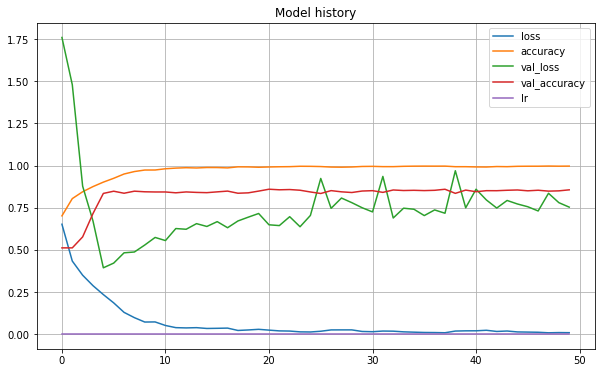

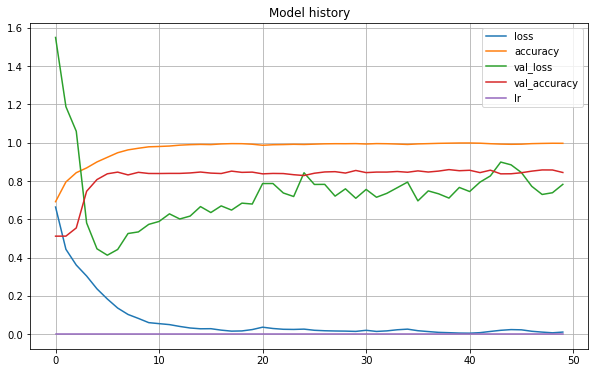

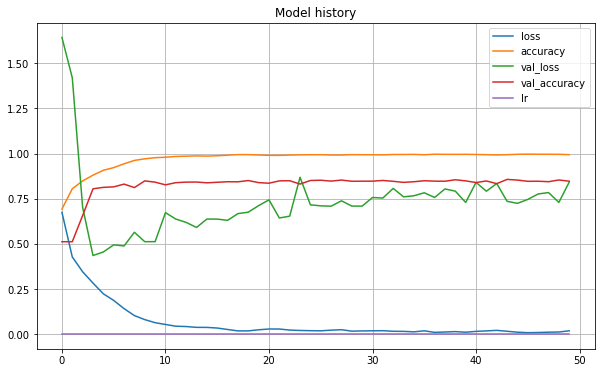

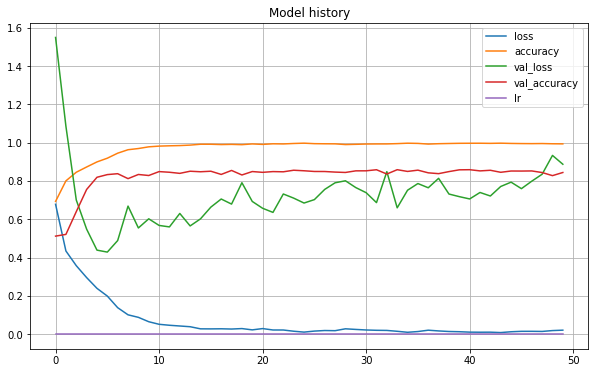

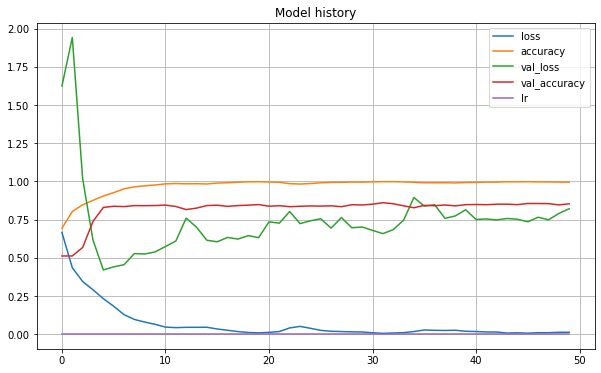

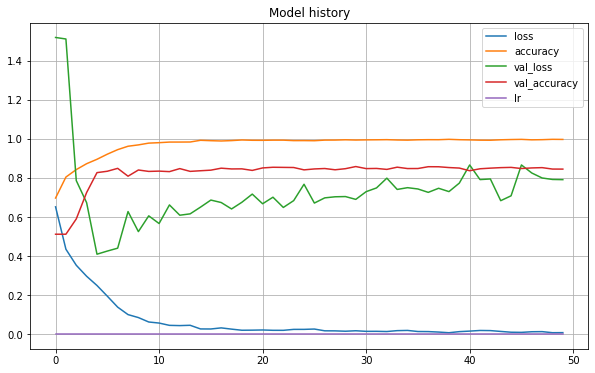

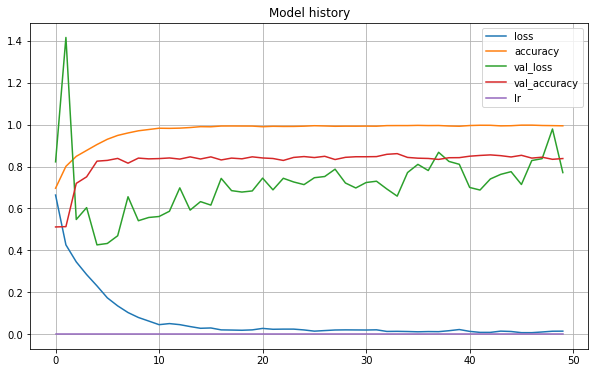

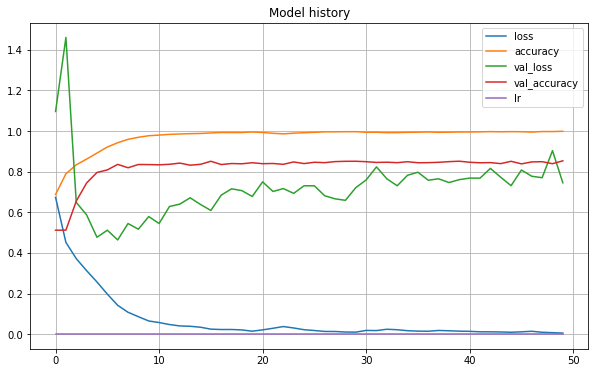

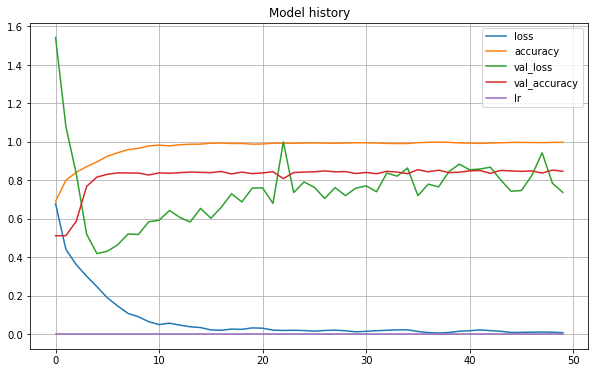

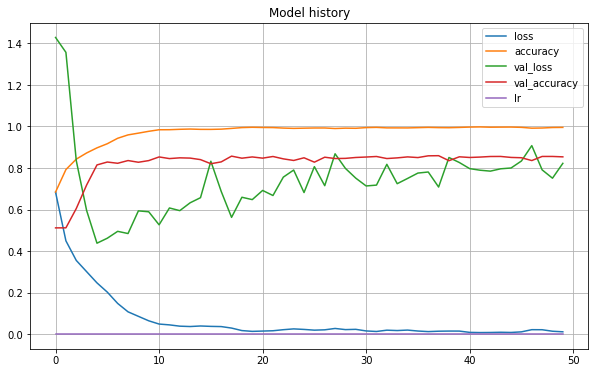

In [16]:
from sklearn.metrics import classification_report, balanced_accuracy_score, roc_auc_score
from sklearn.metrics import normalized_mutual_info_score, mutual_info_score, adjusted_mutual_info_score
N_CLASSES = 2
NUM_RUNS = 10
N_EPOCHS = 50

l1 =0.001

ACC = np.zeros(NUM_RUNS)
AUC = np.zeros(NUM_RUNS)
AUCSK = np.zeros(NUM_RUNS)
MI = np.zeros(NUM_RUNS)
NMI = np.zeros(NUM_RUNS)
AMI = np.zeros(NUM_RUNS)
BACC = np.zeros(NUM_RUNS)
BACC1 = []
MI1 = []
NMI1 =[]
AMI1 = []
AUCSK1 = []

val_acc_goldst= np.zeros(NUM_RUNS)
AUC = np.zeros(NUM_RUNS)
for i in range(NUM_RUNS): #10
    print("iteration: " + str(i))
    model = build_base_model()  
    trainHistory = model.fit(train_batches, validation_data= val_batches, epochs=N_EPOCHS,  callbacks = [callback1, callback2],)
    # Create the history figure
    plt.figure(figsize=(10,6))
    for k in  trainHistory.history:
        plt.plot( trainHistory.history[k],label=k)
    plt.title('Model history')
    plt.legend()
    plt.grid()
  
    #Accuracy
    (loss, accuracy) = model.evaluate(test_batches)
    ACC[i] = accuracy
    
 
     
    #AUC

    val_AUC_metric = tf.keras.metrics.AUC( from_logits = False)
    for x_batch_val, y_batch_val in test_batches:
        val_logits = model(x_batch_val.numpy(), training=False)
        #tf.print(y_batch_val)
       # val_AUC_metric.update_state(y_batch_val, val_logits.numpy().argmax(axis=1).astype('float'))
        val_AUC_metric.update_state(y_batch_val, val_logits.numpy().argmax(axis=1).astype('float'))
        BACC1.append(balanced_accuracy_score(y_batch_val.numpy().squeeze(), val_logits.numpy().argmax(axis=1).squeeze(), adjusted=True))
        MI1.append(mutual_info_score(y_batch_val.numpy().squeeze(), val_logits.numpy().argmax(axis=1).squeeze()))
        NMI1.append(normalized_mutual_info_score(y_batch_val.numpy().squeeze(), val_logits.numpy().argmax(axis=1).squeeze()))
        AMI1.append(normalized_mutual_info_score(y_batch_val.numpy().squeeze(), val_logits.numpy().argmax(axis=1).squeeze()))
        AUCSK1.append(roc_auc_score(ook(y_batch_val.numpy()), val_logits.numpy().astype('float')))

    val_AUC = val_AUC_metric.result()
    val_AUC_metric.reset_states()
    val_AUC = val_AUC.numpy()
    print("Validation AUC: %.4f" % (float(val_AUC),))
    AUC[i] = val_AUC

    #Accurcy
    #ACC[i] = np.array(ACC).mean() # balanced_accuracy_score(Y_true_test.squeeze(), val_logits[:,:K].numpy().argmax(axis=1).squeeze(), adjusted=True)
    print("Validation ACC: %.4f" % (float(ACC[i])))

    # balanced. Accurcy
    BACC[i] = np.array(BACC1).mean() # balanced_accuracy_score(Y_true_test.squeeze(), val_logits[:,:K].numpy().argmax(axis=1).squeeze(), adjusted=True)
    print("Validation Balanced_ACC: %.4f" % (float(BACC[i])))
    AUCSK[i] = np.array(AUCSK1).mean() 
    print("Validation AUCSK: %.4f" % (float( AUCSK[i] )))
    #MI
    
    MI[i] =  np.array(MI1).mean()  #mutual_info_score(Y_true_test.squeeze(), val_logits[:,:K].numpy().argmax(axis=1).squeeze())
    print("Validation MI: %.4f" % (float(MI[i]),))
    NMI[i] =  np.array(NMI1).mean()   #normalized_mutual_info_score(Y_true_test.squeeze(), val_logits[:,:K].numpy().argmax(axis=1).squeeze())
    print("Validation Normalized MI: %.4f" % (float(NMI[i]),))
    AMI[i]= np.array(AMI1).mean()  #adjusted_mutual_info_score(Y_true_test.squeeze(), val_logits[:,:K].numpy().argmax(axis=1).squeeze())
    print("Validation Adjusted MI: %.4f" % (float(AMI[i]),))


In [17]:
print('Average Accuracy: ', np.round( ACC.mean(),4)*100) 
print('Average std: ',np.round(np.std( ACC),4)*100)
print('==============================================')
print('Average AUC: ', np.round( AUC.mean(),4)*100) 
print('Average AUC std: ',np.round(np.std( AUC),4)*100)
print('Average std: ',np.round(np.std( ACC),4)*100)
print('==============================================')
print('Average AUCSK: ', np.round( AUCSK.mean(),4)*100) 
print('Average AUCSK std: ',np.round(np.std( AUCSK),4)*100)
print('==============================================')
print('Average Balanced Accuracy: ', np.round( BACC.mean(),4)*100) 
print('Average std: ',np.round(np.std( BACC),4)*100)
print('==============================================')
print('Average MI: ', np.round( MI.mean(),4)*100) 
print('Average std: ',np.round(np.std(MI),4)*100)
print('==============================================')
print('Average Normalized MI: ', np.round( NMI.mean(),4)*100) 
print('Average std: ',np.round(np.std(NMI),4)*100)
print('==============================================')
print('Average Ajdusted MI: ', np.round( AMI.mean(),4)*100) 
print('Average std: ',np.round(np.std(AMI),4)*100)

Average Accuracy:  85.0
Average std:  0.44
Average AUC:  85.03
Average AUC std:  0.44
Average std:  0.44
Average AUCSK:  93.17999999999999
Average AUCSK std:  0.22999999999999998
Average Balanced Accuracy:  70.19
Average std:  0.44
Average MI:  27.96
Average std:  0.3
Average Normalized MI:  40.660000000000004
Average std:  0.41000000000000003
Average Ajdusted MI:  40.660000000000004
Average std:  0.41000000000000003


In [18]:
# # Training will take around 30 minutes to complete using a GPU. Time for a break!
# N_CLASSES = 2
# NUM_RUNS = 20
# N_EPOCHS = 50
# val_acc_goldst = np.zeros(NUM_RUNS)
# for i in range(NUM_RUNS):
#     model = build_base_model()  
#     trainHistory = model.fit(train_batches, validation_data= val_batches, epochs=N_EPOCHS,  callbacks=callbacks)
#     (loss, accuracy) = model.evaluate(test_batches)
#     ACC[i] = accuracy
#     # Create the history figure
#     plt.figure(figsize=(16,9))
#     for i in trainHistory.history:
#         plt.plot(trainHistory.history[i],label=i)
#     plt.title('Model history')
#     plt.legend()
#     plt.grid()
# import pandas as pd

# df_gold = pd.DataFrame(val_acc_goldst)
# df_gold.to_csv('/kaggle/working/CatDogs_MA_VGG19_GOLD.csv',index=False) # save to notebook output
  

# # plt.plot(trainHistory.history['accuracy'])
# # plt.plot(trainHistory.history['val_accuracy'])
# # plt.ylabel('Accuracy')
# # plt.xlabel('Epoch')
# # plt.legend(['Training', 'Validation'])
# # plt.grid()
# # plt.show()